In [1]:
from deap import base, creator, tools, gp
from deap.algorithms import eaSimple
import math
import numpy
import operator
import random as rd
import lmfit
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')
from sympy import Symbol, expand
from funcoes import malthus, verhulst, gompertz, runge_kutta

In [2]:
T0 = 0
TF = 10
H = 0.1
X0 = 5
A = 0.5

T, X = runge_kutta(malthus, T0, X0, TF, H, A)

In [3]:
def protectedDiv(left, right):
    if type(left) == float:
        if right == 0:
            return 1
        else:
            return left / right
    else:
        # Replace zero terms in the divider array with 1
        right_without_zeros = np.where(right == 0, 1, right)

        # Perform element-wise division
        result = left / right_without_zeros

        return result

def protected_exp(x):

    try:
        result = np.exp(x)
    except OverflowError:
        result = np.ones_like(x)
    return result

    
pset = gp.PrimitiveSet("MAIN", 3)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(protectedDiv, 2)
pset.addPrimitive(operator.neg, 1)
pset.addPrimitive(np.cos, 1)
pset.addPrimitive(np.sin, 1)
pset.addPrimitive(protected_exp, 1)

pset.addEphemeralConstant("rand101", lambda: rd.randint(-1,1))
pset.renameArguments(ARG0='t', ARG1 = 'a', ARG2 = 'b')

In [4]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

In [5]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

In [6]:
def fitness(individual, points):
    # solução numérica:
    # Transformar a expressão em função:
    func = toolbox.compile(expr=individual)
    # Transformar função em modelo para o fit:
    expr_model=lmfit.Model(func)
    expr_model.set_param_hint('a', value=1,vary=True) 
    expr_model.set_param_hint('b', value=1,vary=True) 
    param = expr_model.make_params()
    try:
        results = expr_model.fit(X, t = T, params = param, nan_policy='omit')
        RMSE = np.sqrt(sum(list((np.array(results.best_fit) - np.array(X))**2)))
    except ValueError or TypeError:
        RMSE = float('inf')
        
    #print(np.shape(X), np.shape(T), np.shape(param))
    #results = expr_model.fit(X, t = T, params = param, nan_policy='omit')
    
    #RMSE = np.sqrt(sum(list((np.array(results.best_fit) - np.array(X))**2)))
    tamanho = len(str(individual))
    return (RMSE**2) * tamanho,

In [7]:
toolbox.register("evaluate", fitness, points = list(np.arange(T0, TF + H, H)))
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=2)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

In [8]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

In [9]:
pop = toolbox.population(n=300)
hof = tools.HallOfFame(1)
print(len(pop), mstats)
pop, log = eaSimple(pop, toolbox, 0.5, 0.1, 40, stats=mstats, halloffame=hof, verbose=True)

300 {'fitness': <deap.tools.support.Statistics object at 0x0000021DB22B6280>, 'size': <deap.tools.support.Statistics object at 0x0000021DB22B6550>}
   	      	                      fitness                      	                      size                     
   	      	---------------------------------------------------	-----------------------------------------------
gen	nevals	avg	gen	max	min        	nevals	std	avg    	gen	max	min	nevals	std    
0  	300   	inf	0  	inf	7.15509e+07	300   	nan	3.28667	0  	7  	2  	300   	1.34083
1  	175   	inf	1  	inf	4.16049e+07	175   	nan	2.76   	1  	8  	1  	175   	1.18423
2  	169   	1.99066e+10	2  	5.69621e+12	4.16049e+07	169   	3.2832e+11	2.65667	2  	10 	1  	169   	1.28794
3  	151   	3.26597e+08	3  	2.48364e+09	4.16049e+07	151   	2.75493e+08	2.67333	3  	8  	1  	151   	1.35645
4  	141   	3.31936e+08	4  	3.12399e+10	4.16049e+07	141   	1.80609e+09	2.66   	4  	8  	1  	141   	1.68851
5  	158   	5.08628e+08	5  	1.02117e+11	4.16049e+07	158   	5.88081e+09	2.3

In [10]:
print(str(hof.items[0]))

protected_exp(protectedDiv(add(t, b), a))


protected_exp(protectedDiv(add(t, b), a))


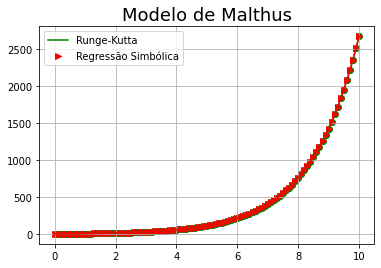

In [11]:
melhor_individuo = str(hof.items[0])
print(melhor_individuo)
func = toolbox.compile(expr=melhor_individuo)
# Transformar função em modelo para o fit:
expr_model=lmfit.Model(func)
expr_model.set_param_hint('a', value=1,vary=True) 
expr_model.set_param_hint('b', value=1,vary=True) 
param = expr_model.make_params()
#print(np.shape(X), np.shape(T), np.shape(param))
results = expr_model.fit(X, t = T, params = param, nan_policy='omit')
RMSE = np.sqrt(sum(list((np.array(results.best_fit) - np.array(X))**2)))

fig, ax = plt.subplots(1,1)
ax.set_title('Modelo de Malthus', size = 18)
ax.scatter(T, X, c = 'g')
ax.plot(T, X, label = 'Runge-Kutta', c = 'g')
ax.scatter(T, results.best_fit, label = 'Regressão Simbólica', marker = '>', c = 'r')
ax.plot(T, results.best_fit,c = 'r')
ax.legend()

ax.legend()
ax.grid('--')
#plt.savefig('Malthus.png', dpi = 200)

In [12]:
# Define your new version of protectedDiv
def new_protectedDiv(x, y):
    # Your new implementation here
    return x / y

# Define your new version of protected_exp
def new_protected_exp(x):
    # Your new implementation here
    return sp.exp(x)

# Create a new primitive set
new_pset = gp.PrimitiveSet("main", arity=3)

# Register the new primitives with the desired names
new_pset.addPrimitive(operator.add, 2)
new_pset.addPrimitive(operator.sub, 2)
new_pset.addPrimitive(operator.mul, 2)
new_pset.addPrimitive(operator.neg, 1)
new_pset.addPrimitive(sp.cos, 1)
new_pset.addPrimitive(sp.sin, 1)
new_pset.addPrimitive(new_protectedDiv, arity=2, name="protectedDiv")
new_pset.addPrimitive(new_protected_exp, arity=1, name="protected_exp")
new_pset.addEphemeralConstant("rand102", lambda: rd.randint(-1,1))
new_pset.renameArguments(ARG0='t', ARG1 = 'a', ARG2 = 'b')
toolbox.register("compile", gp.compile, pset=new_pset)

In [13]:
func = toolbox.compile(expr=melhor_individuo)
t = Symbol('t')
a = Symbol('a')
b = Symbol('b')

In [14]:
display(sp.expand(func(t,a,b)))

exp(b/a)*exp(t/a)